# Proyecto Final - Redes Neuronales Recurrentes
##### Curso: Statistical Learning

## Desarrollo del Problema

**Objetivo general:** Desarrollar un programa de aprendizaje automático para identificar cuándo un artículo puede ser una noticia falsa.

## Carga de Datos

El Dataset contendrá la siguiente información:
* **id:** id único para un artículo de noticias
* **title:** el título de un artículo de noticias
* **author:** autor del artículo de noticias
* **text:** el texto del artículo; podría estar incompleto
* **label:** una etiqueta que marca el artículo como potencialmente no confiable
   - 1: poco confiable
   - 0: confiable

In [24]:
##Importamos algunas librerias que nos servirán en el desarrollo del problema
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Embedding,Dropout,Conv1D,MaxPooling1D,LSTM,Dense
import matplotlib.pyplot as plt
import random
import io

Cargamos la Data.

In [6]:
Full_data = pd.read_csv("dataset3/dataFakeNews.csv")
##LLenamos los espacios que tengan NA/NAN
Full_data = Full_data.fillna(' ')

##Verificamos que haya cargado la información, y que tenga la forma requerida
print('Rango Tensor:',Full_data.ndim)
print('Forma Tensor:',Full_data.shape)
print('Vemos los primeros registros de la data:')
Full_data.head()

Rango Tensor: 2
Forma Tensor: (20800, 5)
Vemos los primeros registros de la data:


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## Análisis Preliminar de los Datos

Obtenemos un listado de las variables y la distribución estadistica de las variables no categoricas.

In [10]:
##Comprobamos los datos que se tienen
Full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20800 non-null  object
 2   author  20800 non-null  object
 3   text    20800 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


La información que se tienen es completamente textos, información númerica es el ID y el label.

## Transformaciones de Texto

Los artículos de noticias pueden utilizar muchas líneas en blanco. El primer paso en cada tarea de procesamiento del lenguaje natural es limpiar el texto, eliminando líneas en blanco y puntuación innecesaria.

Para hacer esto, keras ya ofrece herramientas para limpiar el texto; primero se tokenizará el texto que por defecto en Keras limpia los caracteres especiales, además eliminamos espacios en blanco (asi como nos permite vectorizar el texto para manipular).

In [16]:
# Tokenizamos el Texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Full_data['text'])

In [17]:
#Palabras Descompuestas
word_index = tokenizer.word_index
vocab_size=len(word_index)

In [19]:
# Conversión de Texto a Secuencia y Secuencias de Relleno
sequences = tokenizer.texts_to_sequences(Full_data['text'])
padded = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

Ahora transformar las palabras en números. Hay varias formas de hacer esto, pero para lo que necesitamos usaremos (Word Embedding), ya que en lugar de convertir cada palabra en un número, las palabras se convierten en una representación tensorial.

Para facilitar el Word Embeding utilizaremos un Modelo ya pre-entrenado que garantiza buena fiabilidad para esta operación. Por ejemplo, los investigadores detrás del método GloVe proporcionan un conjunto de Words Embedding previamente entrenadas en su sitio web, publicadas bajo una licencia de dominio público. Ver:
https://nlp.stanford.edu/projects/glove/
GloVe: Vectores globales para la representación de palabras

El paquete más pequeño de incrustaciones es de 822Mb, llamado "glove.6B.zip". Fue entrenado en un conjunto de datos de mil millones de tokens (palabras) con un vocabulario de 400 mil palabras. Hay algunos tamaños de vector de incrustación diferentes, incluidas las dimensiones 50, 100, 200 y 300.

In [20]:
embeddings_index = {};
with open('WordEmbedding/glove.6B.100d.txt',encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

## Separara Datos de Entrenamiento/Validación/Pruebas

Usaremos scikitLearn para hacer la separación de los dataset.
* Entrenamiento (Train) (80%)
* Validación (Cross Validation) (10%)
* Pruebas (Test)(20%) 

In [21]:
from sklearn.model_selection import train_test_split

#Nuestros datos independientes son las secuencias de texto ya tokenizadas
X=padded
Y=Full_data['label'].values

##Hacemos la separación de los data sets
X_Ttrain, X_test, y_Ttrain, y_test = train_test_split(X,Y,test_size=0.2,random_state=21, stratify=Y)
##Volvemos a dividir el de Train para tener otro para Cross-validation
X_train, X_Validation, y_train, y_Validation = train_test_split(X_Ttrain,y_Ttrain,test_size=0.11,random_state=21, stratify=y_Ttrain)

## Creación de Módelos

Creamos nuestro modelo base de la Red Neuronal Secuencial usando Keras.

In [25]:
#Estructura base - Usaremos el modelo base Sequential de Keras
model = Sequential()

#Capa - Word Embedding
model.add(Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False))
model.add(Dropout(0.2))

#Capas Convolucionado
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))

#Capa - Long Short Term Memory (LSTM)
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(20))
model.add(Dropout(0.2))

#Capa - Fully Connected
model.add(Dense(512))
model.add(Dropout(0.3))  
model.add(Dense(256))
model.add(Dense(1, activation='sigmoid'))

Definimos los Hiperparametros para nuestro entrenamiento del modelo y se compila el modelo.

In [26]:
#Definimos los hiperparametros
EPOCHS = 10     #Cantidad de EPOCHS
BS = 32         #Batch Size
#compilar la red
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

Mostramos el Detalle del Modelo creado.

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         23805200  
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          6800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)               

#### Entrenamiento del Modelo

Entrenaremos el Modelo creado.

Tomar en Consideración:
* Se usará **Tensorboard** _(por medio de un callback)_ para ir almacenando las metricas del entrenamiento.
* Se usará **Checkpoints** _(por medio de un callback)_ para almacenar los mejores modelos entrenados, y no volver a repetir entrenamientos.
* Se implementará **Early Stop** _(por medio de un callback)_ para detener el entrenamiento al no mejorar despues de N Epochs.

1. Definición de Callbacks

In [30]:
#Libreria para Timestamp del Proceso y acceso a Sistema
import time
import os

# Nombre Modelo Entrenado - para Checkpoints y log tensorboard
model_name = "Sequential_Recurrent"

#########################
# Callbacks
#########################
#CallBack para almacenar el Log en Tensorboard
strConf=time.strftime("%Y%m%d") + "_"+time.strftime("%H%M%S")+model_name
tensorboard = TensorBoard(log_dir =os.path.join("logsP3", model_name),histogram_freq = 1,profile_batch = '500,520')
#CallBack para almacenar el log en 
checkpoint = ModelCheckpoint(os.path.join("CheckpointsP3", f"{model_name}" + "-loss-{val_loss:.2f}.h5"),
                            save_best_only=True,
                            verbose=1)
#Callbak para Early Stopping
EarlyStop = EarlyStopping(monitor='loss', patience=3)

# Sino esta creado el Folder para los checkpoints- Lo creamos
if not os.path.isdir("CheckpointsP3"):
    os.mkdir("CheckpointsP3")

2. Entrenamiento del Modelo.

In [31]:
H=model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BS, validation_data=[X_test, y_test],
          verbose=1, callbacks=[tensorboard, checkpoint,EarlyStop])

Epoch 1/10
463/463 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.7295
Epoch 00001: val_loss improved from inf to 0.00000, saving model to CheckpointsP3\Sequential_Recurrent-loss-0.00.h5
463/463 [==============================] - 181s 390ms/step - loss: 0.5348 - accuracy: 0.7295 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
 56/463 [==>...........................] - ETA: 2:27 - loss: 0.3754 - accuracy: 0.8449WARNING:tensorflow:From C:\Users\jonathan.deleon\.conda\envs\PythonDev\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
463/463 [==============================] - ETA: 0s - loss: 0.3033 - accuracy: 0.8781
Epoch 00002: val_loss did not improve from 0.00000
463/463 [==============================] - 192s 414ms/step - loss: 0.3033 - accuracy: 0.8781 - val_loss: 0.0

_Nota: Vemos que el modelo con la data de Training consiguio una exactitud (Accuracy) del 97%, lo cual esta bastante bien._

Mostramos los resultados del Entrenamiento en Tensorboard.

**Rendimiento:**
<img src="assets/profileSequentialRecurrent.jpg">

**Metricas (Scalars):**
<img src="assets/metricsSequentialRecurrettest.jpg">

Tambien es facilmente visualizable por medio del History.

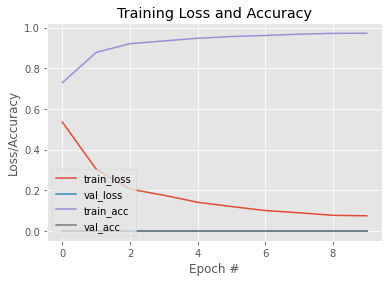

In [34]:
# Graficamos la perdida(loss) y exactitud(accuracy) de la data de entrenamiento y pruebas
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

Mostramos como quedan los checkpoints almacenados, para en algún momento ya utilizar estos modelos ya entrenados.
<img src="assets/sequentialRecurrentcheckpoints.jpg">

#### Almacenamos el Modelo entrenado

Se almacena el modelo entrenado para que pueda ser utilizado posteriormente para predicción.

In [35]:
model.save("finalModels/FakeNews_predictor.model", save_format="h5")

_Nota: Tambien se pudieron utilizar los checkpoints ya almacenados._

### Cross-Validation _(Prueba Deployment)_

Ya se entreno el modelo y ya se ajustaron los hiperparametros para tener buenos resultados con la data de entrenamiento y con la data de Test; ahora para realizar una validación cruzada (cross-validation) y ver la capacidad de predicción del modelo sobre datos nunca vistos.

_**Nota:** Se cargará el modelo almacenado y no se usará el modelo cargado en memoria, con dos objetivos:_
* _Mostrar el Deployment del modelo._
* _No depender de la ejecución de todo el notebook para realizar la comprobación_

1. Cargamos el modelo ya entrenado.

In [36]:
##Cargamos el Modelo Entrenado
from tensorflow.keras.models import load_model

#Cargamos nuestros modelo entrenado para la detección de mascarrillas
Insurance_Model = load_model("finalModels/FakeNews_predictor.model")

2. Realizamos la predicción con los datos de Validación.

In [38]:
#usamos el Modelo ya entrenado para predecir los datos de Validacion
y_hat=Insurance_Model.predict(X_Validation)

In [39]:
#Al ser Sigmoid la función de activación de la última neurona, nos devolverá una probabilidad
#Rendondemos a partir de 0.50 como umbral
y_hat=y_hat.round()

In [40]:
from sklearn.metrics import classification_report

#Imprimimos el Reporte de Clasificación
print(classification_report(y_Validation, y_hat))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       914
           1       0.96      0.96      0.96       917

    accuracy                           0.96      1831
   macro avg       0.96      0.96      0.96      1831
weighted avg       0.96      0.96      0.96      1831



_Nota: Vemos que el modelo con la data de Validación (Cross-Validation) consiguio una exactitud (Accuracy) arriba del del 90%, con un f1-score bastante bueno._